# The Phantom Burster Model
This serves as example for a small explorative notebook.
I implemented the ode system from [The Phantom Burster Model for Pancreatic beta-Cells](https://doi.org/10.1016%2Fs0006-3495%2800%2976525-8) and tried to gain a bit of insight in this model.

The following imports are imports are used in this notebook.
The LaTexStrings is used to match the Plots to my bachelor's thesis style.

In [1]:
using DifferentialEquations
using LaTeXStrings

the "gr()" after the Plots import, sets the backend. The [available backends](https://docs.juliaplots.org/latest/backends/) are liste on the [Plots homepage](https://docs.juliaplots.org/latest/layouts/).
The backend influences the options, features and optics of the produced plots.
If you have used PyPlot before, this can also be importet as a backend.
The "palette = :tab10" in the backend setup functions sets the [color palette](https://docs.juliaplots.org/latest/generated/colorschemes/).
This is overwritten in the very next cell, but I wanted to include it as an example.

The Plots.Measures provides units for setting margins and positions in plots.
I supose the imported "mm" unit may be of more use, than the "px" and "inch" measures.

In [2]:
using Plots; gr(palette = :tab10);
using Plots.Measures

This sets the plot defaults. Those can be overwritten for individual plots.

In [3]:
default(dpi = 250,
 format=:png,
 fontfamily = "Computer Modern",
 titlefontsize  = 14,
 guidefontsize  = 14,
 tickfontsize   = 14,
 legendfontsize = 13,
 framestyle = :default,
 width=1.2,
 palette = :tab10,
 grid = false,
 legend=false
)

The following are helper functions for plotting and analysis of the ode system solutions.
The DifferentialEquations module produces a list of vectors, where each vector corresponds to one timestamp.
For plotin it is more usefull to have a timeseries for every variable.

    [x, y, z]      [x1, x2, x3]
    [x, y, z]  ->  [y1, y2, y3]
    [x, y, z]      [z1, z2, z3]
    
Note, that the solution returned by the "solve" functions, can be plottet directly, this is only for more complex plots.

In [4]:
function rowtocolumn(vec)
    dim1 = length(vec)
    dim2 = length(vec[1])
    vects = Vector{Vector}(undef, dim2)
    map(x -> vects[x] = Array{eltype(vec[1])}(undef, dim1), 1:dim2)
    @inbounds @fastmath for i in 1:dim1, j in 1:dim2
        vects[j][i] = vec[i][j]
    end
    return vects
end

rowtocolumn (generic function with 1 method)

This produces a numerical derivative, by returning a vector with the differences between all neighbouring elements.
Lets go through the first function definition step by step, as it uses many of julias features, that are worth explaining.

    vecdiff(vec::Vector) = 
    
This just defines a function that takes an arguemnt of type Vector.
    
    map((prev, next) -> prev - next, vec, [vec[2:end]; vec[end]])
    
This is the right hand sight. The evaluation of this expression will be returned.

    vec, [vec[2:end]; vec[end]]
    
This are the arguments, of the map-function. Multiple values can be provided and will be handed to the map as tuple.

    [vec[2:end]; vec[end]]

This produces a new vector, which consits of the initial vector from it's seconds element to it's end
and the last element again. This is necessary to make the arguemnts the same length.
This also has the effect to return an output vector that is of equal length as the input.
This is desirable for plotting.

    (prev, next) -> prev - next
    
This is the calculation itself. The map will produce a new vector from the evaluation of this expression for every value of the supplied vectors. 
    
In the second definition, a duration can be applied, so that the derivative will be scaled accordingly.

In [5]:
vecdiff(vec::Vector) = map((prev, next) -> prev - next, vec, [vec[2:end]; vec[end]])
vecdiff(vec::Vector, interval::Number) = vecdiff(vec) ./ (interval ./ length(vec))

vecdiff (generic function with 2 methods)

This is used to save values of intermediate variables of the differential equation in a global variable.
This is a bit ugly, but to my knowledge there is no better way to gain insight into the numerical solver.

In [6]:
function savestats(args)
    push!(stats, collect(args))
end

savestats (generic function with 1 method)

Those are the parameters for the ode system.
The datastrucuture used is called NamedTuple and is immutable.
The parameters could also be saved in a Dict, which is mutable.

In [25]:
params = (
    taus1  = 1000,
    taus2  = 120000,
    tnbar  = 9.09,
    vs1    = -40,
    vs2    = -42,
    s1knot = 1,
    s2knot = 1,
    gl     = 25,
    vl     = -40,
    gk     = 1300,
    vk     = -80,
    gca    = 280,
    vca    = 100,
    lambda = 1.1,
    cm     = 4524,
    vm     = -22,
    sm     = 7.5,
    vn     = -9,
    sn     = 10,
    ss1    = 0.5,
    ss2    = 0.4,
    gs1    = 5,
    gs2    = 32,
);

Following are the functions used in the ode system as seen in the [paper](https://doi.org/10.1016%2Fs0006-3495%2800%2976525-8).

In [8]:
m_inf(V)   = 1/(1+exp((- 22 - V)/7.5))
n_inf(V)   = 1/(1+exp((- 9 - V)/10))  
s1_inf(V)  = 1/(1+exp((- 40 - V)/0.5))
s2_inf(V)  = 1/(1+exp((- 42 - V)/0.4))
tau_inf(V) = 9.09/(1+exp((V+9)/10))    

tau_inf (generic function with 1 method)

This is the differential equation function itself.
It needs to have arguments for the returned change (dy), the current values(y), the parameters (p) and the time (t).
The name of the arguments can be choosen freely. Only the order is important.

In [9]:
function phantom(dy, y, p, t)
    v, n, s1, s2 = y
    minf = 1.0/(1.0+exp((p.vm-v)/p.sm));
    ninf = 1.0/(1.0+exp((p.vn-v)/p.sn));
    taun = p.tnbar/(1.0+exp((v-p.vn)/p.sn));
    s1inf = 1.0/(1.0+exp((p.vs1-v)/p.ss1));
    s2inf = 1.0/(1.0+exp((p.vs2-v)/p.ss2));
    ica = p.gca*minf*(v-p.vca);
    ik = p.gk*n*(v-p.vk);
    il = p.gl*(v-p.vl);
    is1 = p.gs1*s1*(v-p.vk);
    is2 = p.gs2*s2*(v-p.vk);

    savestats((t, minf, ninf, taun, s1inf, s2inf))
    dy[1] = -(ica + ik + il + is1 + is2)/p.cm;
    dy[2] = p.lambda*(ninf - n)/taun;
    dy[3] = (s1inf - s1)/p.taus1;
    dy[4] = (s2inf - s2)/p.taus2;
    return dy
end

phantom (generic function with 1 method)

In [10]:
stats = [] # this is used to save the internal values of the solver
y0 = [-60, 0, 0, 0.6] # initial values

4-element Vector{Float64}:
 -60.0
   0.0
   0.0
   0.6

Julia ode differs from MATLAB, in that an ODEProblem struct is created first and then passed to the solve function.

In [11]:
problem = ODEProblem(phantom, y0, (0.0, 2000.0), params) 

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 2000.0)
u0: 4-element Vector{Float64}:
 -60.0
   0.0
   0.0
   0.6

the solve function takes a ODEProblem as first argument.
Then a numerical solver can be supplied. There are [many builtin algorithms](https://diffeq.sciml.ai/stable/solvers/ode_solve/). The linked site also provides a comparison of the julia functions to MATLAB an python solver.
Other possible keyword arguments can be found [here](https://diffeq.sciml.ai/stable/basics/common_solver_opts/)

The solve function then returns a solutions object, which holds the results.

In [12]:
sol = solve(problem, Tsit5(), saveat=1);

In [13]:
mat = rowtocolumn(sol.u);

If you want to plot multiple vectors over the same x-values, the need to be a vector.

The following plots serve as examples and won't be explained further.
If you are unsure what the othe options do, the [official documentation](http://docs.juliaplots.org/latest/) is quite extensive.

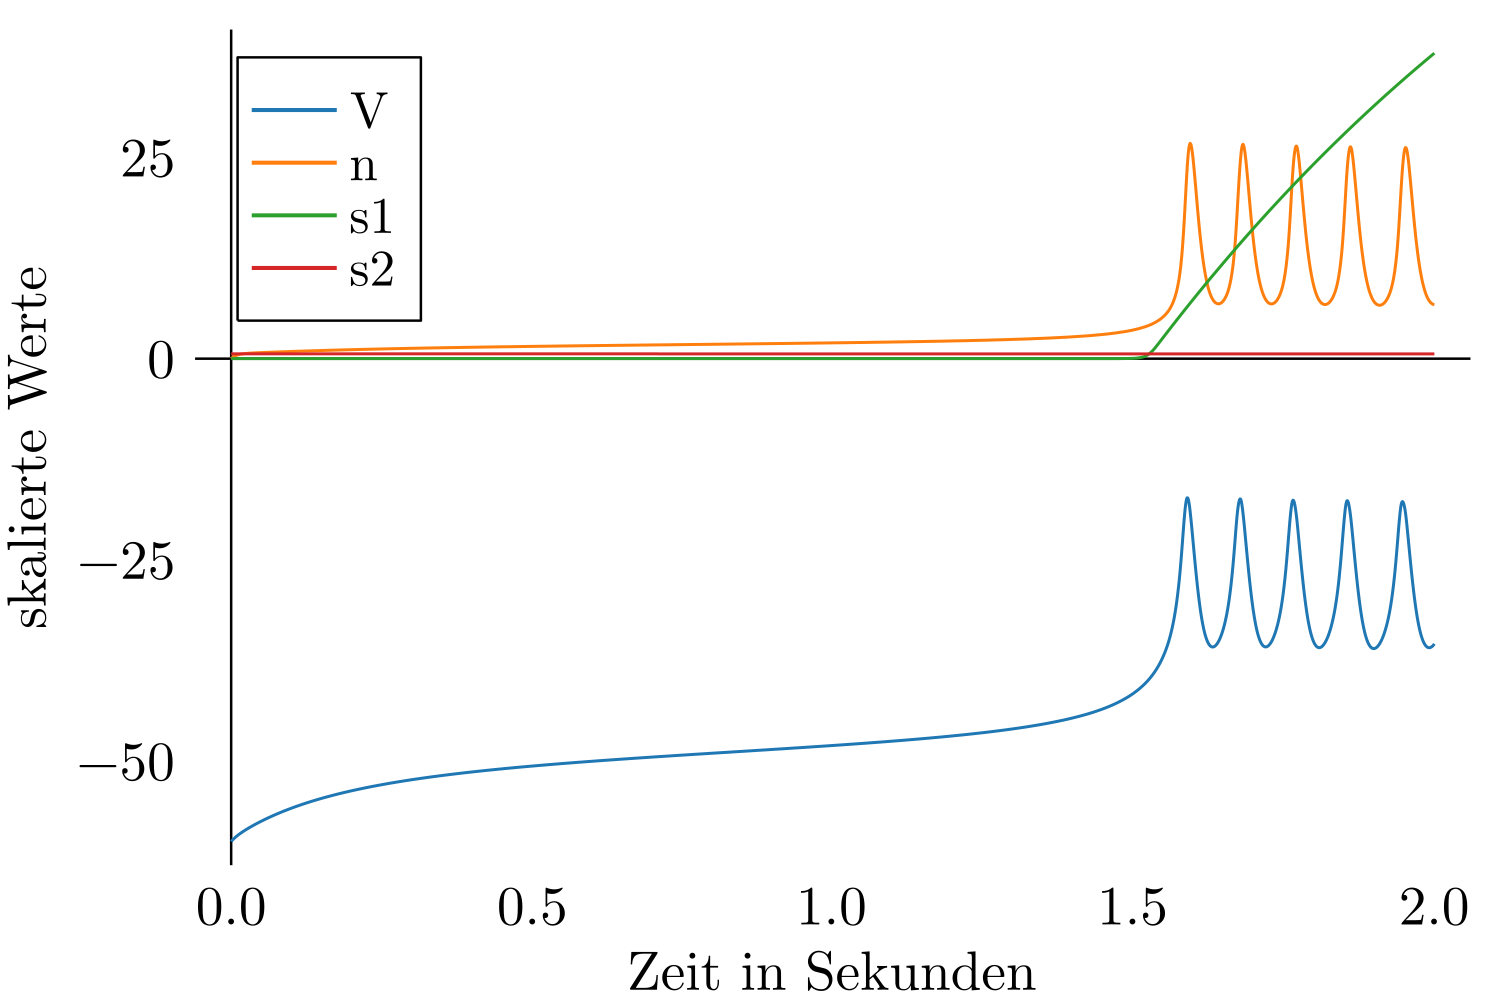

In [14]:
p1 = plot(
    sol.t / 1000,
    [
        mat[1],
        mat[2] * 100,
        mat[3] * 100,
        mat[4],
        ],
    legend = :topleft,
    framestyle = :zerolines,
    label = ["V" "n" "s1" "s2"],
    xlab = "Zeit in Sekunden",
    ylab = "skalierte Werte",
)

In [15]:
s = rowtocolumn(stats);

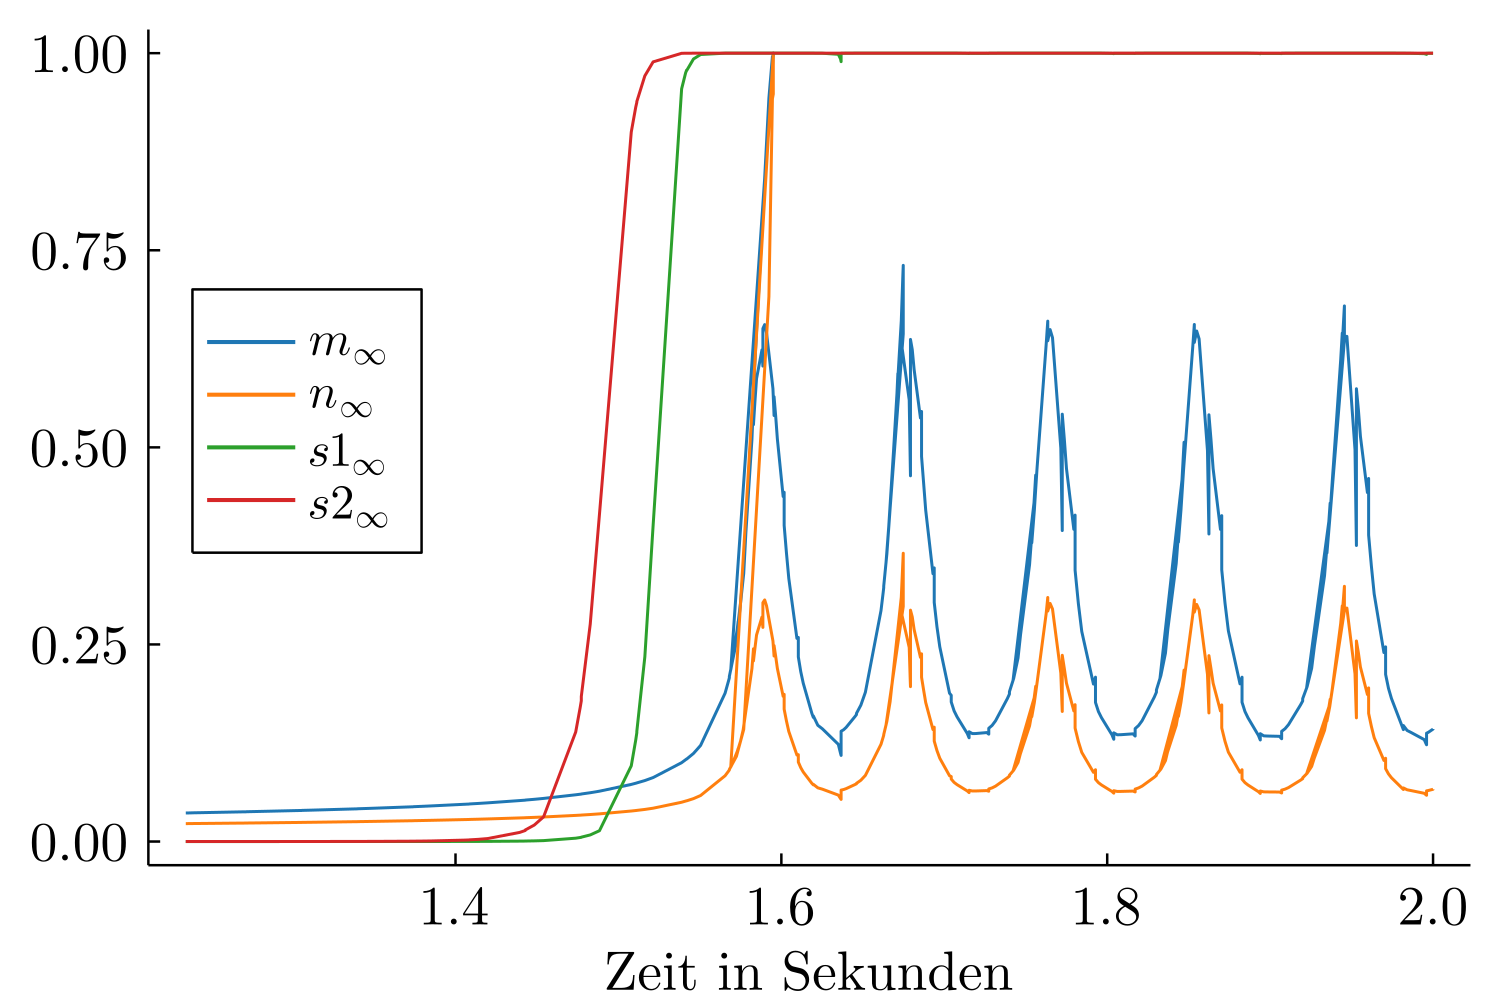

In [16]:
p = map(x -> x[300:end], s)
p2 = plot(
    p[1]/1000,
    p[[2,3,5,6]],
    legend = :left,
    label = [L"$m_\infty$" L"$n_\infty$" L"$s1_\infty$" L"$s2_\infty$"],
    xlab = "Zeit in Sekunden",
)

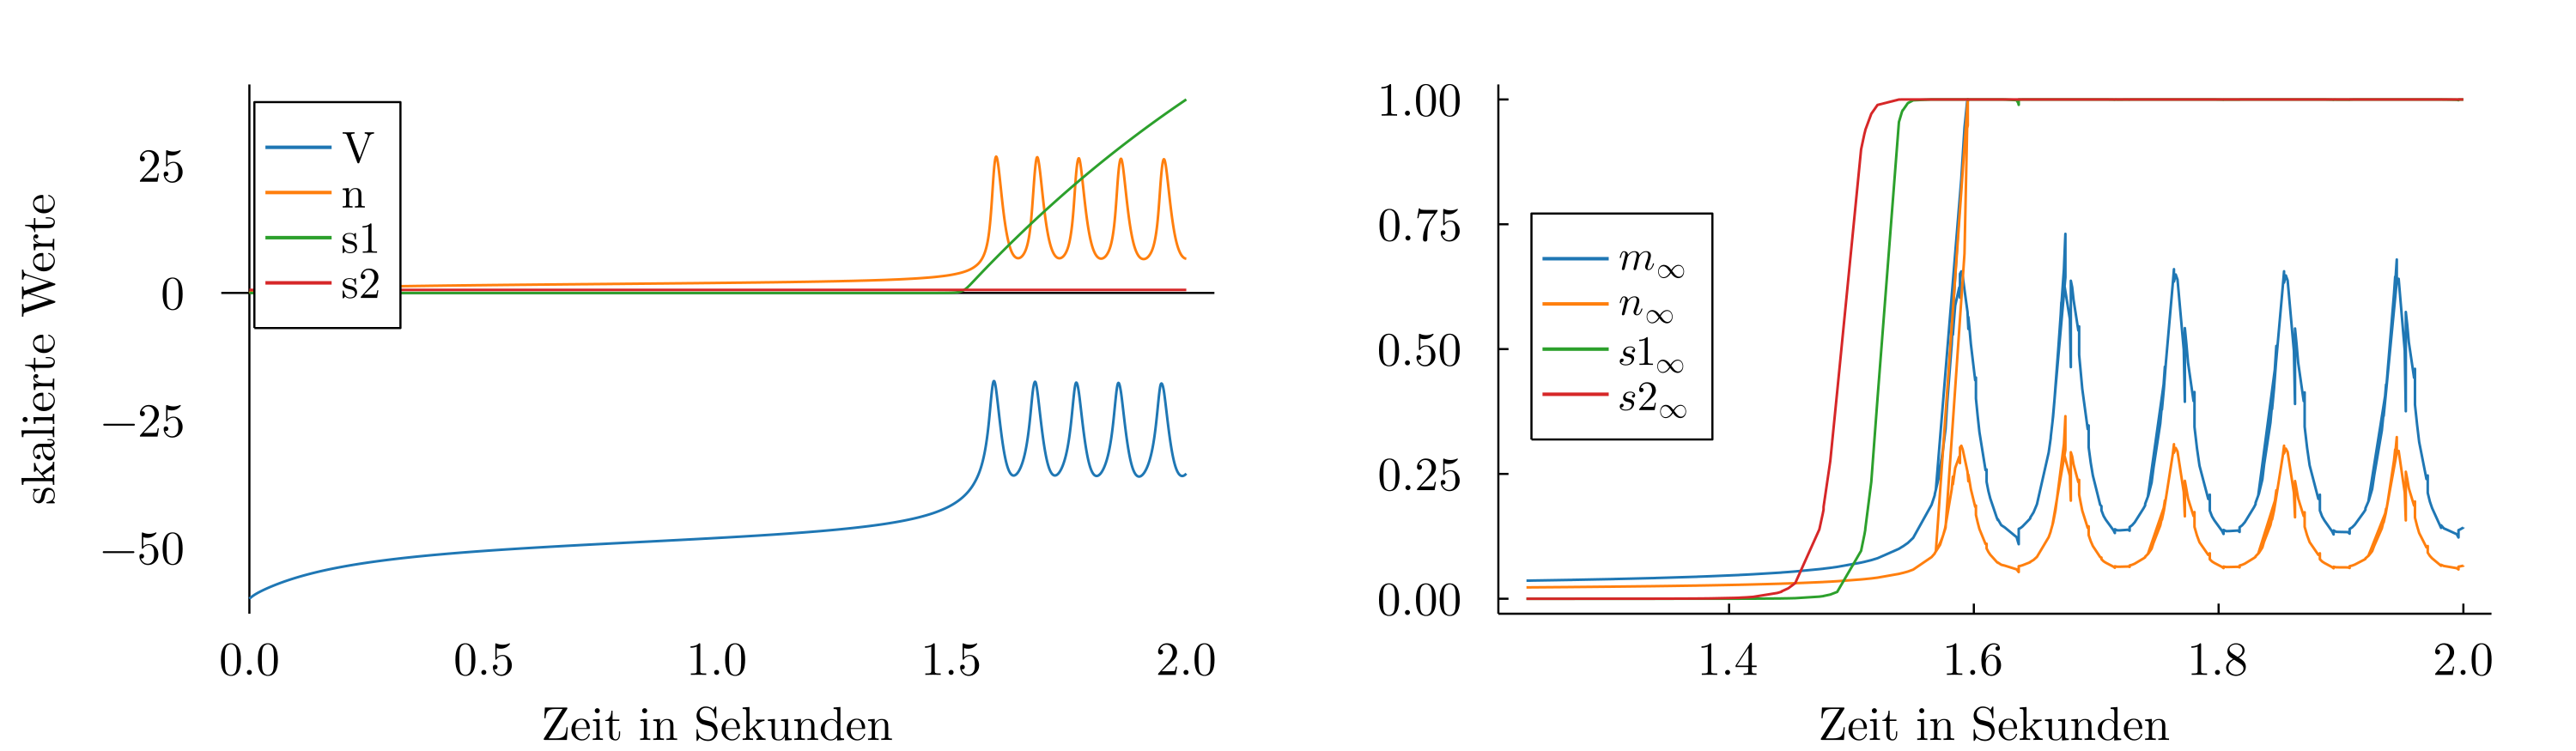

In [17]:
plot(
    p1, 
    p2,
    size = (1200,350), 
    margin = 8mm,
    layout = (1,2),
    xlab = "Zeit in Sekunden",
)

savefig("/home/jonas/tu/ba/assets/pbm_functions.svg")
plot!()

In [18]:
stats = []
y0 = [-60, 0, 0, 0.6]
problem = ODEProblem(phantom, y0, (0.0, 50000.0), params)
sol = solve(problem, Tsit5(), saveat=1);
mat = rowtocolumn(sol.u);

In [19]:
m = rowtocolumn(sol.u);

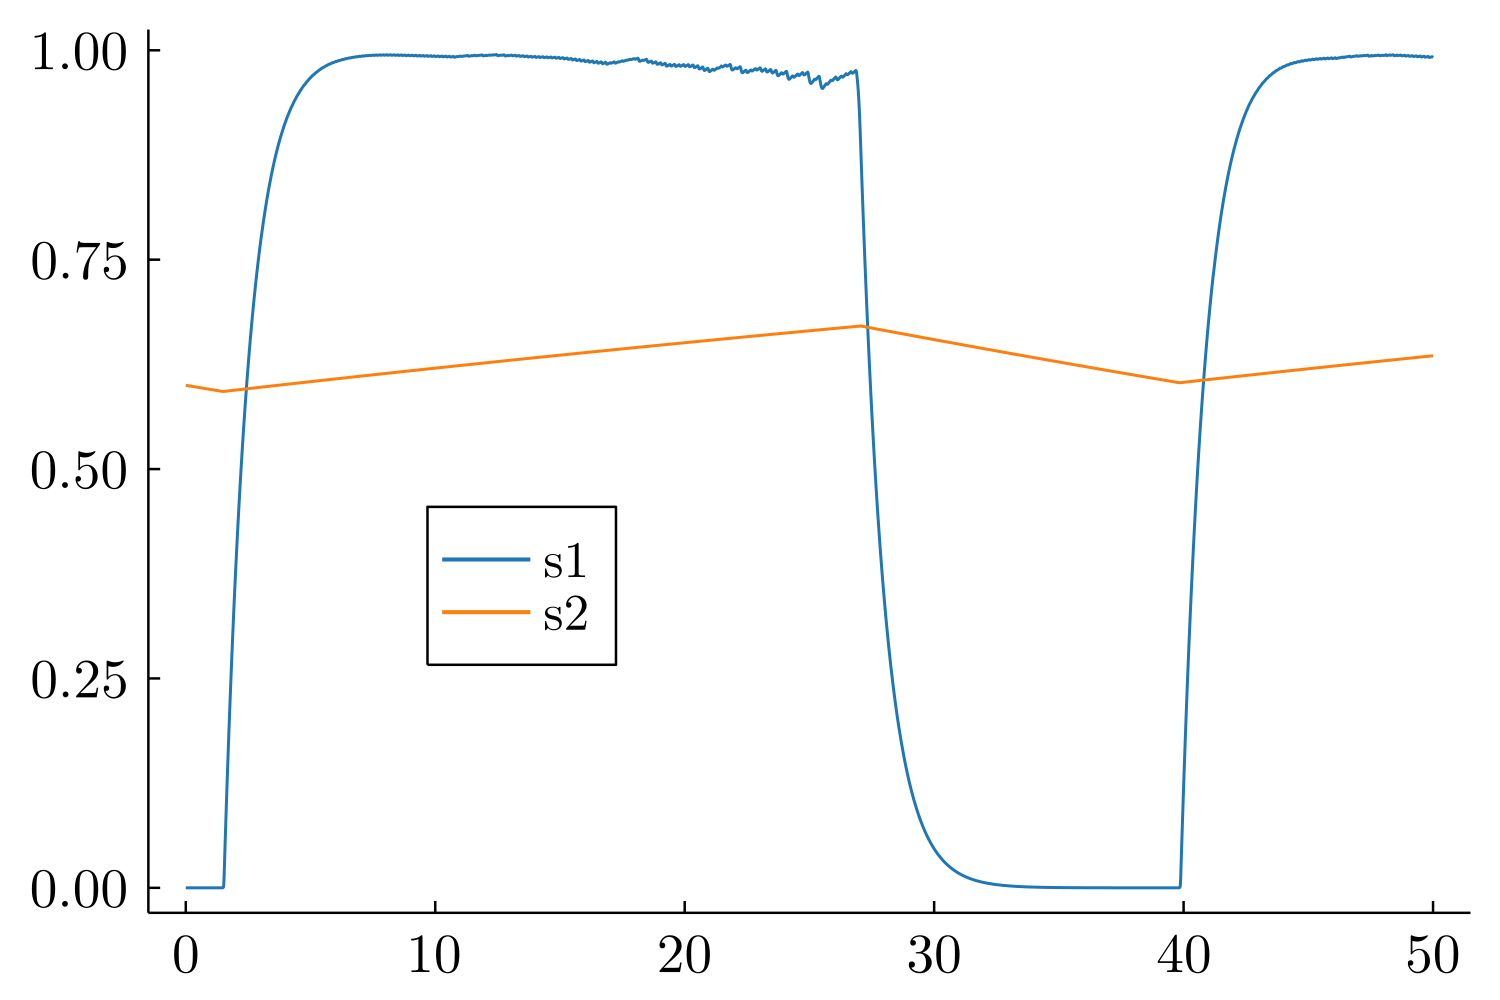

In [20]:
p3 = plot(
    sol.t/1000,
    m[[3,4]],
    legend = (0.3,0.4),
    label = ["s1" "s2"],
)

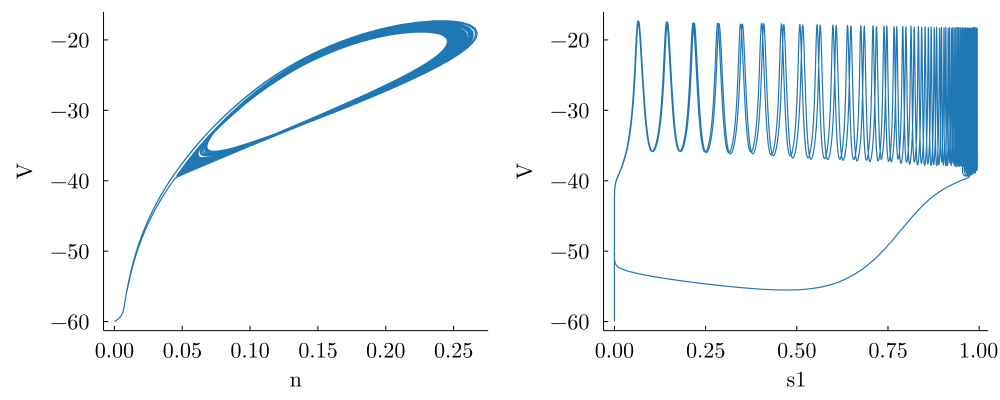

In [21]:
p12 = plot( mat[2],  mat[1], xlab="n", ylab="V" )
p31 = plot( mat[3],  mat[1], xlab="s1", ylab="V" )
plot(p12,p31,
    size=(1000,400),
    layout = grid(1,2, width=[0.8,0.8]),
    format = :svg,
    legend = false,
    bottommargin = 8mm,
    leftmargin = 8mm,
)

#savefig("/home/jonas/tu/ba/assets/phantom_phaseplot.svg")
plot!()

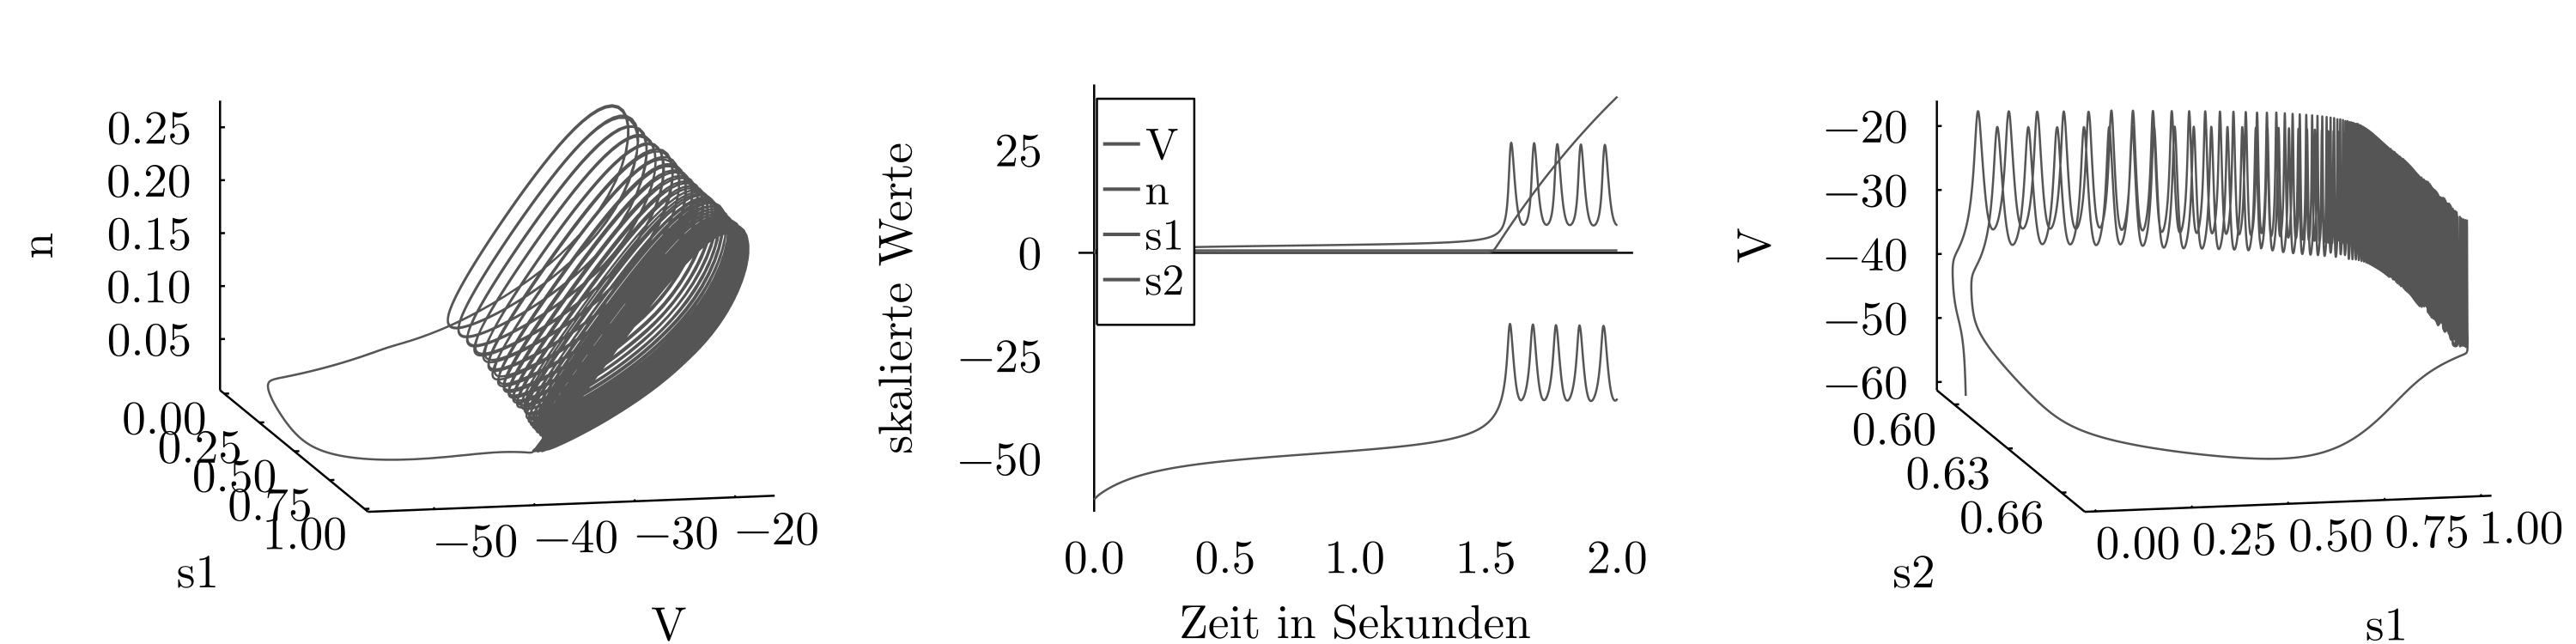

In [22]:
grad = :thermal
plot(
    plot(
        mat[3][400:end],
        mat[1][400:end],
        mat[2][400:end],
        xlab = :s1,
        ylab = :V,
        zlab = :n,
    ),
    p1,
    plot(
        mat[4],
        mat[3],
        mat[1],
        camera = (70,30),
        linewidth = 1,
        lc="#555555",
        size = (600,400),
        xlab = :s2,
        ylab = :s1,
        zlab = :V,
        margin = 5mm,
        xticks = 0.6:0.03:0.7,
    ),
    
    size = (1200,300),
    margin = 8mm,
    linewidth = 1,
    lc="#555555",
    camera = (70,40),
    layout = (1,3),
)

#savefig("/home/jonas/tu/ba/assets/phantom_phase_plot.svg")
plot!()

┌ Info: Saved animation to 
│   fn = /home/jonas/stuff/julia_introduction/tmp.gif
└ @ Plots /home/jonas/.julia/packages/Plots/FCM0H/src/animation.jl:114


Plots.AnimatedGif("/home/jonas/stuff/julia_introduction/tmp.gif")
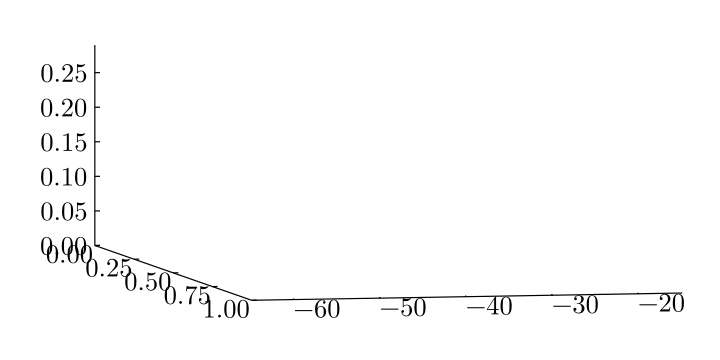

In [23]:
grad = :thermal
@gif for x in 1:50:45000
    if isinteger(x/10)
        print(string(x) * " ")
    end
    plot(
        plot(m[3][1:x],
             m[1][1:x],
             m[2][1:x],
            camera = (70,30),
            lc = "#555555",
            ),
        dpi = 120,
        size = (600,300),
        xticks = 0:0.25:1,
        yticks = -60:10:0,
        zticks = 0:0.05:0.25,
        xlim = (0,1),
        ylim = (-65,-15),
        zlim = (0,0.29),
        margin = 6mm,
    )
end